# Import necessary libraries

In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


# Background Information

The dataset is provided by the Radiological Society of North America and is accessible on Kaggle. (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

The dataset contains 26,684 X-Ray images
  + 20,672 images without pneumonia
  + 6,012 images with pneumonia



# Preprocessing

To-Do List:
  + Resize image from 1024x1024 to 224x224
  + Standardize the pixel values into the interval [0, 1]
  + Split dataset into train and test sets
  + Store converted images in folders corresponding to the class
    - 0 if no pneumonia
    - 1 if pneumonia
  + Apply data augmentation

## Load Data

In [3]:
labels = pd.read_csv("../data/raw/stage_2_train_labels.csv")
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


As the X-RAY images are stored in DICOM format and named with patientID, we will only need the unique patientID:

In [4]:
labels = labels.drop_duplicates("patientId")

In [5]:
INPUT_PATH = Path("../data/raw/stage_2_train_images/")
INTER_PATH = Path("../data/interim/")

In [6]:
def get_dicom_pixel_array(index, path, labels):
  patient_id = labels.patientId.iloc[index]
  dicom_path = path/patient_id
  dicom_path = dicom_path.with_suffix(".dcm")
  dicom_pixel_array = pydicom.read_file(dicom_path).pixel_array
  return dicom_pixel_array

## Initial Visualization

In [7]:
def init_visualize(row, column, labels, path, index=0, figsize=(9, 9)):
  fig, ax = plt.subplots(row, column, figsize=figsize)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  for i in range(row):
    for j in range(column):
      dicom_pixel_array = get_dicom_pixel_array(index=index, path=path, labels=labels)
      
      label = labels["Target"].iloc[index]
      
      ax[i][j].imshow(dicom_pixel_array, cmap="bone")
      if label == 0:
        ax[i][j].set_title(f"Negative")
      else:
        ax[i][j].set_title(f"Positive")
      index += 1

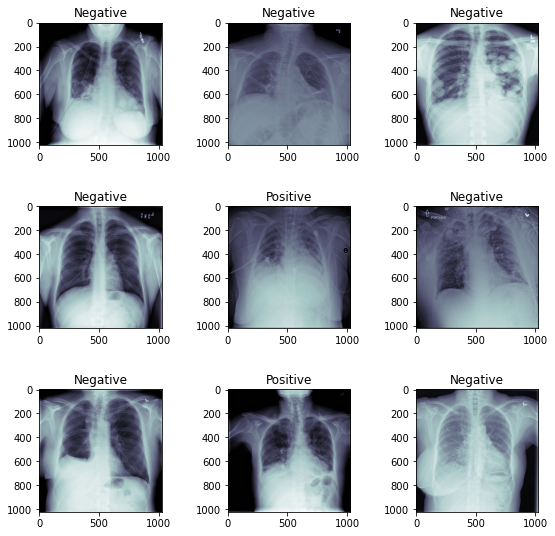

In [8]:
init_visualize(row=3, column=3, labels=labels, index=0, path=INPUT_PATH, figsize=(9, 9))

In [9]:
sums, sums_squared = 0, 0

for index, patient_id in enumerate(tqdm(labels.patientId)):
  # Standardize by dividing by 255
  dicom_pixel_array = get_dicom_pixel_array(index=index, path=INPUT_PATH, labels=labels) / 255
  # Resize to 224x224 and store as numpy array
  dicom_array = cv2.resize(dicom_pixel_array, (224, 224)).astype(np.float16)
  # Create directories and save the resize image
  class_path = labels.Target.iloc[index]
  train_or_val_path = "train" if index < 24000 else "val"
  interim_data_path = INTER_PATH/train_or_val_path/str(class_path)
  interim_data_path.mkdir(parents=True, exist_ok=True)
  np.save(interim_data_path/patient_id, dicom_array)
  
  normalizer = 224*224
  if train_or_val_path == "train":
    sums += np.sum(dicom_array) / normalizer
    sums_squared += (dicom_array ** 2).sum() / normalizer
  

  0%|          | 0/26684 [00:00<?, ?it/s]

In [10]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [12]:
mean_std = (mean, std)
variable_path = Path("../data/interim/variables")
variable_path.mkdir(parents=True, exist_ok=True)
np.save(variable_path/"mean_std", mean_std)